# Appling machine learning to audio analysis

### Trainning Code

In [1]:
### Dependencies were already installed previously on ubuntu
### Comet: experiment tracking and visual tools

from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [2]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2022-01-06 19:55:47.596722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-06 19:55:47.596825: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# To play audio file:
import IPython.display as ipd

In [ ]:
# Create a Comet Experiment, to capture any and all artifacts
# such as audio files, visualization, model, dataset, system information and training metrics
experiment = Experiment(api_key = "Xa6eGiuYFngDcAJ9PVY1WpZp0", project_name = "SetA")

## MFCCs - Mel-Frequency Cepstrum Coefficients

### Function to extract the MFCCs from every file in our dataset

In [ ]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
     
    return mfccs_processed

In [ ]:
df = pd.read_csv('../csvFiles/newTiming.csv')

In [ ]:
from os.path import exists

In [ ]:
sounds = []# Iterate through each sound file and extract the sound type
cont = 0 #Conta os ficheiros que tiveram os MFCCs analizados
i = 0 # numero total de ficheiros

for index, row in df.iterrows():
    file_name = df.loc[index]['fname']
    class_label = df.loc[index]['sound']
    
    if 'noise' in class_label:
        class_label = 'noise'
    
    print(class_label)
    i+=1
    
    if (exists(file_name)):
        file_size = os.path.getsize(file_name)
        
        if (file_size > 44):
            data = extract_features(file_name)
            
            sounds.append([data, class_label])
            cont += 1
        else:
            print(file_name)
            
print(i, cont)
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(sounds, columns=['soundtype','class_label'])

In [ ]:
featuresdf
featuresdf.iloc[799]['class_label']
featuresdf.to_pickle('../MFCCs/cutA_toTrain.pkl') 

## Model building and training

### Load MFFCs from saved files

In [5]:
fileMFCCs = '../MFCCs/cutA_toTrain.pkl'
featuresdf = pd.read_pickle(fileMFCCs)

### Transform the data to arrays

In [6]:

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.soundtype.tolist())
y = np.array(featuresdf.class_label.tolist())


# Encode the classification labels
le = LabelEncoder()

yy = to_categorical(le.fit_transform(y))

### Trainning and test sets

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

### Neural Network architecture

In [8]:
keras.backend.clear_session()
num_labels = yy.shape[1]

filter_size = 2

def build_model_graph(input_shape=(40,)):
    model = Sequential()
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 
    
    return model

model = build_model_graph()

# Display model architecture summary 
model(x_train)
model.summary()# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

2022-01-06 19:56:04.068538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-06 19:56:04.068619: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-06 19:56:04.068664: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (chico-VirtualBox): /proc/driver/nvidia/version does not exist
2022-01-06 19:56:04.070021: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (640, 512)                20992     
                                                                 
 activation (Activation)     (640, 512)                0         
                                                                 
 dropout (Dropout)           (640, 512)                0         
                                                                 
 dense_1 (Dense)             (640, 512)                262656    
                                                                 
 activation_1 (Activation)   (640, 512)                0         
                                                                 
 dropout_1 (Dropout)         (640, 512)                0         
                                                                 
 dense_2 (Dense)             (640, 512)                2

### Model Trainning

In [23]:
num_epochs = 20
num_batch_size = 32

csv_logger = keras.callbacks.CSVLogger('../model_save/cut_setA_Train_Hist.log')

model.fit(x_train, y_train, batch_size=num_batch_size,callbacks=[csv_logger], epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Epoch 1/20
20/20 [==============================] - 1s 37ms/step - loss: 0.3388 - accuracy: 0.8422 - val_loss: 0.6512 - val_accuracy: 0.8375
Epoch 2/20
20/20 [==============================] - 1s 28ms/step - loss: 0.3191 - accuracy: 0.8469 - val_loss: 0.6605 - val_accuracy: 0.8375
Epoch 3/20
20/20 [==============================] - 1s 26ms/step - loss: 0.2935 - accuracy: 0.8641 - val_loss: 0.6643 - val_accuracy: 0.8125
Epoch 4/20
20/20 [==============================] - 1s 39ms/step - loss: 0.3438 - accuracy: 0.8313 - val_loss: 0.8002 - val_accuracy: 0.8000
Epoch 5/20
20/20 [==============================] - 0s 23ms/step - loss: 0.3418 - accuracy: 0.8328 - val_loss: 0.6360 - val_accuracy: 0.8188
Epoch 6/20
20/20 [==============================] - 0s 24ms/step - loss: 0.3582 - accuracy: 0.8344 - val_loss: 0.7799 - val_accuracy: 0.8062
Epoch 7/20
20/20 [==============================] - 0s 22ms/step - loss: 0.3515 - accuracy: 0.8562 - val_loss: 0.6611 - val_accuracy: 0.7937
Epoch 8/20
20

In [24]:
model.save('../model_save/cut_setA', save_format='tf')

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.842188,0.338754,0.83750,0.651154
1,1,0.846875,0.319059,0.83750,0.660483
2,2,0.864062,0.293513,0.81250,0.664341
3,3,0.831250,0.343811,0.80000,0.800178
4,4,0.832812,0.341806,0.81875,0.635972
5,5,0.834375,0.358237,0.80625,0.779942
6,6,0.856250,0.351477,0.79375,0.661100
7,7,0.859375,0.307201,0.79375,0.592554
8,8,0.850000,0.332197,0.81250,0.638115
9,9,0.857813,0.311159,0.82500,0.651137


In [33]:
history = pd.read_csv('../model_save/cut_setA_Train_Hist.log')

### Plot of model performance

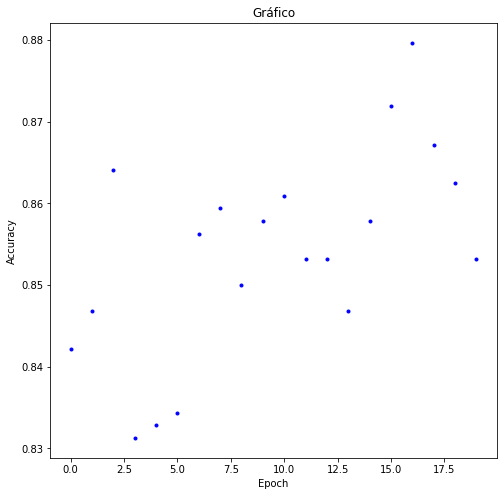

In [34]:
xx = np.array(history.epoch.tolist())
yy = np.array(history.accuracy.tolist())

fig = plt.figure(figsize=(8,8))
Plot = fig.add_subplot(111)

Plot.plot(xx, yy, "b.")

#Plot.axvline(x=Ei, c='red')
#Plot.axhline(y=npy.log(tauN), c='purple')

Plot.title.set_text("Gráfico")
Plot.set_xlabel("Epoch")
Plot.set_ylabel("Accuracy")
plt.show()

In [ ]:
experiment.end()